# (1) Import Libraries


In [63]:
# Data Handling
import pandas as pd
import numpy as np
import math
import scipy.stats as sps
#from scipy import stats, integrate
from datetime import datetime

# sklearn and models
from sklearn import preprocessing, ensemble, metrics, feature_selection, model_selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, recall_score, precision_score, classification_report, accuracy_score, roc_curve, roc_auc_score, RocCurveDisplay
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

#plotting and display
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

### Contents:
- [Background](#Background)
- [Data Import & Cleaning](#Data-Import-&-Cleaning)
- [Feature Engineering](#Feature-Engineering)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Modeling](#Modeling)
    - [Fine Tuning of Best Models](#Fine-Tuning-of-Best-Models)
    - [Best Model Evaluation](#Best-Model-Evaluation)
- [Key Insights & Recommendations](#Key-Insights-&-Recommendations)
- [Kaggle Submission](#Kaggle-Submission)

## Background

insert awesome Background here

# Data Import & Cleaning

## Load Data

In [2]:
# create date parser
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

# create data type converters
dtype_map_weather = dict(Station = 'str')
dtype_map_test_train = dict(Block = 'str', Street = 'str')

# read data into PANDAS DataFrames with date parsing
test = pd.read_csv('data/test.csv', parse_dates=['Date'], date_parser=dateparse, dtype= dtype_map_test_train)
train = pd.read_csv('data/train.csv', parse_dates=['Date'], date_parser=dateparse, dtype= dtype_map_test_train)
weather = pd.read_csv('data/weather.csv', parse_dates=['Date'], date_parser=dateparse, dtype= dtype_map_weather)
sample_sub = pd.read_csv('data/sampleSubmission.csv')

In [3]:
#set option
pd.set_option('display.max_column', 50)

#Displaying all imported csv files
display(train.head(1))
print(f"Train Data")
display(train.info())

display(test.head(1))
print(f"Test Data")
display(test.info())

display(weather.head(1))
print(f"Weather Data")
display(weather.info())

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


Train Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  object        
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), i

None

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


Test Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  object        
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 9.8+ MB


None

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2


Weather Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   object        
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object       

None

In [4]:
display(train['WnvPresent'].value_counts())

# Assuming your DataFrame is named 'df'
rows_with_wnv_present = train[train['WnvPresent'] == 1]
rows_with_wnv_present.tail(5)

0    9955
1     551
Name: WnvPresent, dtype: int64

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
10388,2013-09-19,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,27,1
10439,2013-09-26,"4600 Milwaukee Avenue, Chicago, IL 60630, USA",CULEX PIPIENS,46,N MILWAUKEE AVE,T003,"4600 N MILWAUKEE AVE, Chicago, IL",41.964242,-87.757639,8,3,1
10462,2013-09-26,"6300 West 64th Street, Chicago, IL 60638, USA",CULEX PIPIENS/RESTUANS,63,W 64TH ST,T155,"6300 W 64TH ST, Chicago, IL",41.776156,-87.778927,9,4,1
10484,2013-09-26,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,39,1
10501,2013-09-26,"5100 West 72nd Street, Chicago, IL 60638, USA",CULEX PIPIENS/RESTUANS,51,W 72ND ST,T035,"5100 W 72ND ST, Chicago, IL",41.763733,-87.742302,8,6,1


In [5]:
# weather
weather_exclude = ['Dewpoint', 'WetBulb', 'CodeSum', 'Depth', 'Water1', 'SnowFall', 'StnPressure',
                 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed','DewPoint']
weather_cols = [col for col in weather.columns if col not in weather_exclude]
weather = weather[weather_cols]
print(f"Train Data")
display(weather.info())


# train
train_exclude = ['Address', 'AddressNumberAndStreet', 'AddressAccuracy', 'NumMosquitos']
train_cols = [col for col in train.columns if col not in train_exclude]
train = train[train_cols]
print(f"Test Data")
display(train.info())

# test
test_exclude = ['Address', 'AddressNumberAndStreet', 'AddressAccuracy', 'Id']
test_cols = [col for col in test.columns if col not in test_exclude]
test = test[test_cols]
print(f"Weather Data")
display(test.info())

Train Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   object        
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   Heat         2944 non-null   object        
 7   Cool         2944 non-null   object        
 8   Sunrise      2944 non-null   object        
 9   Sunset       2944 non-null   object        
 10  PrecipTotal  2944 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 253.1+ KB


None

Test Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        10506 non-null  datetime64[ns]
 1   Species     10506 non-null  object        
 2   Block       10506 non-null  object        
 3   Street      10506 non-null  object        
 4   Trap        10506 non-null  object        
 5   Latitude    10506 non-null  float64       
 6   Longitude   10506 non-null  float64       
 7   WnvPresent  10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 656.8+ KB


None

Weather Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       116293 non-null  datetime64[ns]
 1   Species    116293 non-null  object        
 2   Block      116293 non-null  object        
 3   Street     116293 non-null  object        
 4   Trap       116293 non-null  object        
 5   Latitude   116293 non-null  float64       
 6   Longitude  116293 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 6.2+ MB


None

## the train and test df have no null values.

In [6]:
# what species have been detected (note that according to the CDC each
# of these species can carry WNV)
display(set(train.Species))

# does this correspond to the test set
display(set(test.Species))
# it looks like there is another category

{'CULEX ERRATICUS',
 'CULEX PIPIENS',
 'CULEX PIPIENS/RESTUANS',
 'CULEX RESTUANS',
 'CULEX SALINARIUS',
 'CULEX TARSALIS',
 'CULEX TERRITANS'}

{'CULEX ERRATICUS',
 'CULEX PIPIENS',
 'CULEX PIPIENS/RESTUANS',
 'CULEX RESTUANS',
 'CULEX SALINARIUS',
 'CULEX TARSALIS',
 'CULEX TERRITANS',
 'UNSPECIFIED CULEX'}

## The species are the same except for unspecified culex.

In [7]:
train.groupby('Species').sum(numeric_only=True)['WnvPresent']


Species
CULEX ERRATICUS             0
CULEX PIPIENS             240
CULEX PIPIENS/RESTUANS    262
CULEX RESTUANS             49
CULEX SALINARIUS            0
CULEX TARSALIS              0
CULEX TERRITANS             0
Name: WnvPresent, dtype: int64

### only 3 species of mosquitos will lead to a WnvPresent.

## Handle Missing Data

- What is 'T' and 'M'?

"M" stands for "Missing". Data for an element will be missing if the primary sensor for that weather element is inoperable (e.g., has an outage) or malfunctioning (e.g., producing errant data) AND any collocated backup sensor is also inoperable or malfunctioning. "T" stand for "Trace". This is a small amount of precipitation that will wet a raingage but is less than the 0.01 inch measuring limit.

The Precipitation Total column is the only column in the retained data that can contain this value. The value has leading whitespace so we should strip prior to counting

In [8]:
# Checking for 'M' and 'T'
for column in weather.columns:
    value_counts = weather[column].value_counts()
    print(f"Value counts for column '{column}':\n{value_counts}\n")

Value counts for column 'Station':
1    1472
2    1472
Name: Station, dtype: int64

Value counts for column 'Date':
2007-05-01    2
2012-06-28    2
2012-07-07    2
2012-07-06    2
2012-07-05    2
             ..
2009-08-29    2
2009-08-28    2
2009-08-27    2
2009-08-26    2
2014-10-31    2
Name: Date, Length: 1472, dtype: int64

Value counts for column 'Tmax':
84     128
79     121
82     118
81     117
83     109
      ... 
102      2
103      2
104      1
42       1
41       1
Name: Tmax, Length: 63, dtype: int64

Value counts for column 'Tmin':
63    121
65    111
60    109
61    106
62    105
57    103
66    103
68    103
64    101
59    100
56     98
69     95
71     95
58     94
70     90
67     89
54     81
49     78
52     74
50     72
55     71
53     71
47     69
44     59
46     58
43     58
51     57
45     55
48     55
72     50
73     46
42     46
41     38
40     33
74     29
39     29
75     28
38     22
37     21
36     20
77     20
34     12
35     11
33     10
79   

In [9]:
# strip whitespace
weather.PrecipTotal = weather.PrecipTotal.str.strip()

# define new variables to hand M, - and T
miss_weather = ['M', '-', 'T']

# define new columns
cols_not_date = [col for col in weather.columns if col != 'Date']

# fill the M, - and T with 0
weather[cols_not_date].apply(pd.value_counts, axis=1)[miss_weather].fillna(0).sum()

M    1507.0
-    2944.0
T     318.0
dtype: float64

In [10]:
# To have a better sense of the data
values_to_count = ['M', 'T', '-']

for column in weather.columns:
    value_counts = weather[column].value_counts()
    missing_values_counts = value_counts[value_counts.index.isin(values_to_count)]
    print(f"Value counts for missing values in column '{column}':\n{missing_values_counts}\n")

Value counts for missing values in column 'Station':
Series([], Name: Station, dtype: int64)

Value counts for missing values in column 'Date':
Series([], Name: Date, dtype: int64)

Value counts for missing values in column 'Tmax':
Series([], Name: Tmax, dtype: int64)

Value counts for missing values in column 'Tmin':
Series([], Name: Tmin, dtype: int64)

Value counts for missing values in column 'Tavg':
M    11
Name: Tavg, dtype: int64

Value counts for missing values in column 'Depart':
M    1472
Name: Depart, dtype: int64

Value counts for missing values in column 'Heat':
M    11
Name: Heat, dtype: int64

Value counts for missing values in column 'Cool':
M    11
Name: Cool, dtype: int64

Value counts for missing values in column 'Sunrise':
-    1472
Name: Sunrise, dtype: int64

Value counts for missing values in column 'Sunset':
-    1472
Name: Sunset, dtype: int64

Value counts for missing values in column 'PrecipTotal':
T    318
M      2
Name: PrecipTotal, dtype: int64



In [11]:
# Both stations
check = weather[cols_not_date].apply(pd.value_counts, axis=0).fillna(0)
check.loc[['M', '-', 'T']]

# check = weather[cols_not_date].apply(pd.value_counts, axis=0).fillna(0)
# check.loc[['M', '-', 'T']]

,Station,Tmax,Tmin,Tavg,Depart,Heat,Cool,Sunrise,Sunset,PrecipTotal
M,0.0,0.0,0.0,11.0,1472.0,11.0,11.0,0.0,0.0,2.0
-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1472.0,1472.0,0.0
T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,318.0


In [12]:
check_stat1 = weather[cols_not_date][weather.Station == '1'].apply(pd.value_counts, axis=0).fillna(0)
labels_to_print = ['M', '-', 'T']

# Filter the labels that are not in the index
labels_not_in_index = [label for label in labels_to_print if label not in check_stat1.index]

# Append the missing labels to the DataFrame
missing_labels_df = pd.DataFrame(index=labels_not_in_index, columns=check_stat1.columns).fillna(np.nan)
check_stat1 = pd.concat([check_stat1, missing_labels_df])

# Print the resulting DataFrame
check_stat1.loc[labels_to_print]

,Station,Tmax,Tmin,Tavg,Depart,Heat,Cool,Sunrise,Sunset,PrecipTotal
M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163.0


In [13]:
# Station 2
check_stat2 = weather[cols_not_date][weather.Station == '2'].apply(pd.value_counts, axis= 0).fillna(0)
check_stat2.loc[['M', '-', 'T']]


,Station,Tmax,Tmin,Tavg,Depart,Heat,Cool,Sunrise,Sunset,PrecipTotal
M,0.0,0.0,0.0,11.0,1472.0,11.0,11.0,0.0,0.0,2.0
-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1472.0,1472.0,0.0
T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,155.0


In [14]:
# Both stations percentage missing data
check.loc[['M', '-', 'T']]/(len(weather)) * 100

,Station,Tmax,Tmin,Tavg,Depart,Heat,Cool,Sunrise,Sunset,PrecipTotal
M,0.0,0.0,0.0,0.373641,50.0,0.373641,0.373641,0.0,0.0,0.067935
-,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,50.0,50.0,0.000000
T,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,10.801630


In [15]:
# Station 1
check_stat1.loc[['M', '-', 'T']]/(len(weather)) * 100

,Station,Tmax,Tmin,Tavg,Depart,Heat,Cool,Sunrise,Sunset,PrecipTotal
M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.536685


In [16]:
# Station 2()
check_stat2.loc[['M', '-', 'T']]/(len(weather)) * 100

,Station,Tmax,Tmin,Tavg,Depart,Heat,Cool,Sunrise,Sunset,PrecipTotal
M,0.0,0.0,0.0,0.373641,50.0,0.373641,0.373641,0.0,0.0,0.067935
-,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,50.0,50.0,0.000000
T,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,5.264946


In [17]:
# fill the missing values with NaN
weather = weather.replace('M', np.NaN)
weather = weather.replace('-', np.NaN)
# very small amounts of rain can impact mosquito hatches
weather = weather.replace('T', 0.005) 

# VERY IMPORTANT. We are filling up the Missing Values with Forward Filling Method
weather.Depart = weather.Depart.fillna(method = 'ffill')
weather.Heat = weather.Heat.fillna(method = 'ffill')
weather.Cool = weather.Cool.fillna(method = 'ffill')
weather.PrecipTotal = weather.PrecipTotal.fillna(method = 'ffill')


In [18]:
# convert datatpypes

to_numeric = ['Tmax','Tmin','Tavg', 'Depart', 'Heat', 'Cool', 'PrecipTotal']

for col in to_numeric:
    weather[col]= pd.to_numeric(weather[col])

In [19]:
weather.Sunrise = weather.Sunrise.fillna(method = 'ffill')
weather.Sunset = weather.Sunset.fillna(method = 'ffill')

In [20]:
# sunset has entries where instead of incrementing to the next hour after xx59 it incremented to xx60
# This causes an exception, let's take a look
counter = 0
tracker = []
for index, val in enumerate(weather.Sunset):
    try:
        pd.to_datetime(val, format = '%H%M').time()
    except:
        counter += 1
        tracker.append((index, val, val[2:], counter))
# print(tracker[-1])
# Output
# (20, '1860', '60', 1)
# (21, '1860', '60', 2)
# (276, '1760', '60', 3)
# (277, '1760', '60', 4)
# (348, '1660', '60', 5)

### there are 48 exceptions with problematic entries, where all of them ending with '60'.
### we will change the 60 to 59.

In [21]:
# let's deal with this by decrmenting by 1 for each invalid instance
weather.Sunset = weather.Sunset.replace('\+?60', '59', regex = True)

In [22]:
# time conversion lambda function
time_func = lambda x: pd.Timestamp(pd.to_datetime(x, format = '%H%M'))

weather.Sunrise = weather.Sunrise.apply(time_func)
weather.Sunset = weather.Sunset.apply(time_func)

In [23]:
# what is the range of values for sunrise and sunset (in hours)
minutes= (weather.Sunset - weather.Sunrise).astype('timedelta64[m]')
hours = minutes/60
# hours
# 0       14.016667
# 1       14.016667
# 2       14.050000
# 3       14.050000
# 4       14.083333
#           ...    
# 2939    10.500000
# 2940    10.450000
# 2941    10.450000
# 2942    10.400000
# 2943    10.400000
set(np.round(hours.values))

{10.0, 11.0, 12.0, 13.0, 14.0, 15.0}

In [24]:
# create a DayLength column with minute level precison
weather['DayLength_MPrec'] = (weather.Sunset - weather.Sunrise).astype('timedelta64[m]')/60

# sample weather['DayLength_MPrec']
# 0       14.016667
# 1       14.016667

# create a DayLength column with rounded to the nearest hour
weather['DayLength_nearH'] = np.round(((weather.Sunset - weather.Sunrise).astype('timedelta64[m]')/60).values)

# weather['DayLength_nearH']
# 0       14.0
# 1       14.0

# create a NightLength column with minute level precision
weather['NightLength_MPrec'] = 24.0 - weather.DayLength_MPrec

# weather['NightLength_MPrec']
# 0        9.983333
# 1        9.983333

# create a NightLength column with minute level precision
weather['NightLength_nearH'] = 24.0 - weather.DayLength_nearH

# weather['NightLength_nearH']
# 0       10.0
# 1       10.0

In [25]:
# function to calculate sunset and sunrise times in hours
hours_RiseSet_func = lambda x: x.minute/60.0 + float(x.hour)

# sunrise in hours
weather['Sunrise_hours'] = weather.Sunrise.apply(hours_RiseSet_func)

# sample weather['Sunrise_hours']
# 0       4.800000
# 1       4.800000

# sunset in hours
weather['Sunset_hours'] = weather.Sunset.apply(hours_RiseSet_func)

# sample weather['Sunrise_hours']
# 0       18.816667
# 1       18.816667

In [26]:
# mass define the names of new blended columns
blend_cols = ['Tmax', 'Tmin', 'Depart' ,'Heat', 'Cool', 'PrecipTotal']
blended_cols= ['blended_' + col for col in blend_cols]

# get the values from the weather columns
station_1 = weather[blend_cols][weather.Station == '1']
station_2 = weather[blend_cols][weather.Station == '2']

# use the values obtained above to average it out
station_blend = pd.DataFrame((station_1.values + station_2.values)/2, columns= blended_cols)

# call out the entire dataframe for station 1 and station 2 (without the blending columns)
extract_1 = weather[weather.Station == '1'].reset_index(drop = True)
extract_2 = weather[weather.Station == '2'].reset_index(drop = True)

# call out the entire dataframe for station 1 and station 2 (with the blending columns)
joined_1 = extract_1.join(station_blend)
joined_2 = extract_2.join(station_blend)


In [27]:
# this is the finalised 
weather_blend = pd.concat([joined_1, joined_2])
display(weather_blend)
display(weather_blend.info())

,Station,Date,Tmax,Tmin,Tavg,Depart,Heat,Cool,Sunrise,Sunset,PrecipTotal,DayLength_MPrec,DayLength_nearH,NightLength_MPrec,NightLength_nearH,Sunrise_hours,Sunset_hours,blended_Tmax,blended_Tmin,blended_Depart,blended_Heat,blended_Cool,blended_PrecipTotal
0,1,2007-05-01,83,50,67.0,14,0,2,1900-01-01 04:48:00,1900-01-01 18:49:00,0.000,14.016667,14.0,9.983333,10.0,4.800000,18.816667,83.5,51.0,14.0,0.0,2.5,0.0000
1,1,2007-05-02,59,42,51.0,-3,14,0,1900-01-01 04:47:00,1900-01-01 18:50:00,0.000,14.050000,14.0,9.950000,10.0,4.783333,18.833333,59.5,42.5,-3.0,13.5,0.0,0.0000
2,1,2007-05-03,66,46,56.0,2,9,0,1900-01-01 04:46:00,1900-01-01 18:51:00,0.000,14.083333,14.0,9.916667,10.0,4.766667,18.850000,66.5,47.0,2.0,8.0,0.0,0.0000
3,1,2007-05-04,66,49,58.0,4,7,0,1900-01-01 04:44:00,1900-01-01 18:52:00,0.005,14.133333,14.0,9.866667,10.0,4.733333,18.866667,72.0,50.0,4.0,7.0,0.0,0.0025
4,1,2007-05-05,66,53,60.0,5,5,0,1900-01-01 04:43:00,1900-01-01 18:53:00,0.005,14.166667,14.0,9.833333,10.0,4.716667,18.883333,66.0,53.5,5.0,5.0,0.0,0.0050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2,2014-10-27,79,54,67.0,16,0,2,1900-01-01 06:18:00,1900-01-01 16:53:00,0.020,10.583333,11.0,13.416667,13.0,6.300000,16.883333,78.0,52.5,16.0,0.5,1.0,0.0100
1468,2,2014-10-28,66,48,57.0,10,8,0,1900-01-01 06:19:00,1900-01-01 16:51:00,0.030,10.533333,11.0,13.466667,13.0,6.316667,16.850000,67.0,46.5,10.0,8.0,0.0,0.0175
1469,2,2014-10-29,49,40,45.0,-4,20,0,1900-01-01 06:20:00,1900-01-01 16:50:00,0.000,10.500000,10.0,13.500000,14.0,6.333333,16.833333,49.0,38.0,-4.0,21.0,0.0,0.0000
1470,2,2014-10-30,53,37,45.0,-4,20,0,1900-01-01 06:22:00,1900-01-01 16:49:00,0.005,10.450000,10.0,13.550000,14.0,6.366667,16.816667,52.0,34.5,-4.0,21.5,0.0,0.0025


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2944 entries, 0 to 1471
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Station              2944 non-null   object        
 1   Date                 2944 non-null   datetime64[ns]
 2   Tmax                 2944 non-null   int64         
 3   Tmin                 2944 non-null   int64         
 4   Tavg                 2933 non-null   float64       
 5   Depart               2944 non-null   int64         
 6   Heat                 2944 non-null   int64         
 7   Cool                 2944 non-null   int64         
 8   Sunrise              2944 non-null   datetime64[ns]
 9   Sunset               2944 non-null   datetime64[ns]
 10  PrecipTotal          2944 non-null   float64       
 11  DayLength_MPrec      2944 non-null   float64       
 12  DayLength_nearH      2944 non-null   float64       
 13  NightLength_MPrec    2944 non-nul

None

### Moving on to train.csv and test.csv

In [28]:
# create functions to abstract month, day, day_of_year and week_of_year functions
month_func = lambda x: x.month
day_func= lambda x: x.day
day_of_year_func = lambda x: x.dayofyear
week_of_year_func = lambda x: x.week

# train
train['month'] = train.Date.apply(month_func)
train['day'] = train.Date.apply(day_func)
train['day_of_year'] = train.Date.apply(day_of_year_func)
train['week'] = train.Date.apply(week_of_year_func)

# sample train['week']
# 0        22
# 1        22
# 2        22
# 3        22

# test
test['month'] = test.Date.apply(month_func)
test['day'] = test.Date.apply(day_func)
test['day_of_year'] = test.Date.apply(day_of_year_func)
test['week'] = test.Date.apply(week_of_year_func)


### Create integer latitude and longitude columns
train['Lat_int'] = train.Latitude.apply(int)
train['Long_int'] = train.Longitude.apply(int)
test['Lat_int'] = test.Latitude.apply(int)
test['Long_int'] = test.Longitude.apply(int)

In [29]:
# sanity check
display(train.describe())
display(test.describe())

,Latitude,Longitude,WnvPresent,month,day,day_of_year,week,Lat_int,Long_int
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.0
mean,41.841139,-87.699908,0.052446,7.692557,15.341424,217.941938,31.687131,41.038930,-87.0
std,0.112742,0.096514,0.222936,1.067675,8.901205,31.735797,4.526874,0.193438,0.0
min,41.644612,-87.930995,0.000000,5.000000,1.000000,148.000000,22.000000,41.000000,-87.0
25%,41.732984,-87.760070,0.000000,7.000000,7.000000,196.000000,28.000000,41.000000,-87.0
50%,41.846283,-87.694991,0.000000,8.000000,15.000000,217.000000,31.000000,41.000000,-87.0
75%,41.954690,-87.627796,0.000000,8.000000,24.000000,241.000000,35.000000,41.000000,-87.0
max,42.017430,-87.531635,1.000000,10.000000,31.000000,282.000000,41.000000,42.000000,-87.0


,Latitude,Longitude,month,day,day_of_year,week,Lat_int,Long_int
count,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.0
mean,41.849389,-87.693658,7.620244,16.187681,217.057304,31.417833,41.039925,-87.0
std,0.106593,0.080699,1.065842,8.800007,32.536523,4.660725,0.195784,0.0
min,41.644612,-87.930995,6.000000,1.000000,153.000000,22.000000,41.000000,-87.0
25%,41.753411,-87.750938,7.000000,10.000000,193.000000,28.000000,41.000000,-87.0
50%,41.862292,-87.694991,8.000000,17.000000,217.000000,31.000000,41.000000,-87.0
75%,41.951866,-87.648860,8.000000,24.000000,244.000000,35.000000,41.000000,-87.0
max,42.017430,-87.531635,10.000000,31.000000,275.000000,40.000000,42.000000,-87.0


In [30]:
# remove sunrise and sunset since we have extracted critical information into other fields
weather_blend = weather_blend.drop(['Sunrise', 'Sunset'], axis= 1)

In [31]:
train = train.merge(weather_blend, on='Date')
test = test.merge(weather_blend, on='Date')

### Checking dataframe whether it makes sense

In [32]:
display(weather_blend.iloc[:,:12].describe())
display(weather_blend.iloc[:,12:].describe())

,Tmax,Tmin,Tavg,Depart,Heat,Cool,PrecipTotal,DayLength_MPrec,DayLength_nearH,NightLength_MPrec
count,2944.000000,2944.000000,2933.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000
mean,76.166101,57.810462,67.240027,1.954484,3.417799,5.641304,0.131780,13.669384,13.646739,10.330616
std,11.461970,10.381939,10.545442,6.839947,5.955153,6.104849,0.393031,1.489822,1.485758,1.489822
min,41.000000,29.000000,36.000000,-17.000000,0.000000,0.000000,0.000000,10.400000,10.000000,8.766667
25%,69.000000,50.000000,60.000000,-3.000000,0.000000,0.000000,0.000000,12.512500,12.750000,9.045833
50%,78.000000,59.000000,69.000000,2.000000,0.000000,4.000000,0.000000,14.233333,14.000000,9.766667
75%,85.000000,66.000000,75.000000,7.000000,5.000000,10.000000,0.060000,14.954167,15.000000,11.487500
max,104.000000,83.000000,94.000000,23.000000,29.000000,29.000000,6.860000,15.233333,15.000000,13.600000


,NightLength_nearH,Sunrise_hours,Sunset_hours,blended_Tmax,blended_Tmin,blended_Depart,blended_Heat,blended_Cool,blended_PrecipTotal
count,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.00000
mean,10.353261,4.992663,18.662047,76.166101,57.810462,1.954484,3.417799,5.641304,0.13178
std,1.485758,0.651771,0.843787,11.422764,10.268370,6.839947,5.932802,6.061981,0.35829
min,9.000000,4.266667,16.783333,41.500000,29.000000,-17.000000,0.000000,0.000000,0.00000
25%,9.000000,4.412500,18.033333,68.500000,50.500000,-3.000000,0.000000,0.000000,0.00000
50%,10.000000,4.775000,18.983333,78.500000,59.500000,2.000000,0.000000,4.000000,0.00250
75%,11.250000,5.520833,19.370833,84.500000,65.500000,7.000000,4.500000,10.500000,0.08000
max,14.000000,6.383333,19.516667,103.500000,82.500000,23.000000,29.000000,28.500000,4.85500


In [33]:
train.describe()

,Latitude,Longitude,WnvPresent,month,day,day_of_year,week,Lat_int,Long_int,Tmax,Tmin,Tavg,Depart,Heat,Cool,PrecipTotal,DayLength_MPrec,DayLength_nearH,NightLength_MPrec,NightLength_nearH,Sunrise_hours,Sunset_hours,blended_Tmax,blended_Tmin,blended_Depart,blended_Heat,blended_Cool,blended_PrecipTotal
count,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.0,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000
mean,41.841139,-87.699908,0.052446,7.692557,15.341424,217.941938,31.687131,41.038930,-87.0,81.917095,63.647202,73.022463,2.740244,0.886208,8.908671,0.146082,14.006641,13.968304,9.993359,10.031696,4.890621,18.897262,81.917095,63.647202,2.740244,0.886208,8.908671,0.146082
std,0.112739,0.096512,0.222930,1.067649,8.900993,31.735042,4.526766,0.193433,0.0,8.290251,7.593949,7.501455,6.486313,2.712230,5.755434,0.378659,1.048358,1.047465,1.048358,1.047465,0.463813,0.589987,8.272521,7.486933,6.486313,2.697339,5.712594,0.323131
min,41.644612,-87.930995,0.000000,5.000000,1.000000,148.000000,22.000000,41.000000,-87.0,57.000000,41.000000,50.000000,-12.000000,0.000000,0.000000,0.000000,11.383333,11.000000,8.766667,9.000000,4.266667,17.333333,57.500000,42.500000,-12.000000,0.000000,0.000000,0.000000
25%,41.732984,-87.760070,0.000000,7.000000,7.000000,196.000000,28.000000,41.000000,-87.0,78.000000,59.000000,70.000000,-2.000000,0.000000,5.000000,0.000000,13.300000,13.000000,9.050000,9.000000,4.483333,18.533333,78.000000,59.500000,-2.000000,0.000000,5.000000,0.000000
50%,41.846283,-87.694991,0.000000,8.000000,15.000000,217.000000,31.000000,41.000000,-87.0,83.000000,65.000000,75.000000,4.000000,0.000000,10.000000,0.000000,14.300000,14.000000,9.700000,10.000000,4.816667,19.116667,83.000000,65.500000,4.000000,0.000000,9.500000,0.000000
75%,41.954690,-87.627796,0.000000,8.000000,24.000000,241.000000,35.000000,41.000000,-87.0,88.000000,69.000000,79.000000,8.000000,0.000000,14.000000,0.110000,14.950000,15.000000,10.700000,11.000000,5.233333,19.400000,88.000000,69.500000,8.000000,0.000000,13.500000,0.130000
max,42.017430,-87.531635,1.000000,10.000000,31.000000,282.000000,41.000000,42.000000,-87.0,97.000000,79.000000,87.000000,18.000000,15.000000,22.000000,3.970000,15.233333,15.000000,12.616667,13.000000,5.950000,19.516667,96.500000,77.500000,18.000000,14.000000,20.500000,2.420000


## Preparing Data for Model Fitting

In [34]:
# columns to write
cols_to_write = [col for col in train.columns if col != 'Date'] # exclude 'Date'

In [35]:
# split the data into two dataframes by station

train_station_1= train[train.Station == '1']
train_station_2= train[train.Station == '2']

test_station_1= test[test.Station == '1']
test_station_2= test[test.Station == '2']

train_station_1

,Date,Species,Block,Street,Trap,Latitude,Longitude,WnvPresent,month,day,day_of_year,week,Lat_int,Long_int,Station,Tmax,Tmin,Tavg,Depart,Heat,Cool,PrecipTotal,DayLength_MPrec,DayLength_nearH,NightLength_MPrec,NightLength_nearH,Sunrise_hours,Sunset_hours,blended_Tmax,blended_Tmin,blended_Depart,blended_Heat,blended_Cool,blended_PrecipTotal
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,0,5,29,149,22,41,-87,1,88,60,74.0,10,0,9,0.0,14.933333,15.0,9.066667,9.0,4.350000,19.283333,88.0,62.5,10.0,0.0,10.5,0.0
2,2007-05-29,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,0,5,29,149,22,41,-87,1,88,60,74.0,10,0,9,0.0,14.933333,15.0,9.066667,9.0,4.350000,19.283333,88.0,62.5,10.0,0.0,10.5,0.0
4,2007-05-29,CULEX RESTUANS,62,N MANDELL AVE,T007,41.994991,-87.769279,0,5,29,149,22,41,-87,1,88,60,74.0,10,0,9,0.0,14.933333,15.0,9.066667,9.0,4.350000,19.283333,88.0,62.5,10.0,0.0,10.5,0.0
6,2007-05-29,CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,41.974089,-87.824812,0,5,29,149,22,41,-87,1,88,60,74.0,10,0,9,0.0,14.933333,15.0,9.066667,9.0,4.350000,19.283333,88.0,62.5,10.0,0.0,10.5,0.0
8,2007-05-29,CULEX RESTUANS,79,W FOSTER AVE,T015,41.974089,-87.824812,0,5,29,149,22,41,-87,1,88,60,74.0,10,0,9,0.0,14.933333,15.0,9.066667,9.0,4.350000,19.283333,88.0,62.5,10.0,0.0,10.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21002,2013-09-26,CULEX PIPIENS/RESTUANS,51,W 72ND ST,T035,41.763733,-87.742302,1,9,26,269,39,41,-87,1,75,50,63.0,3,2,0,0.0,11.983333,12.0,12.016667,12.0,5.716667,17.700000,75.0,52.5,3.0,1.0,0.0,0.0
21004,2013-09-26,CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,41.987280,-87.666066,0,9,26,269,39,41,-87,1,75,50,63.0,3,2,0,0.0,11.983333,12.0,12.016667,12.0,5.716667,17.700000,75.0,52.5,3.0,1.0,0.0,0.0
21006,2013-09-26,CULEX PIPIENS/RESTUANS,17,N ASHLAND AVE,T232,41.912563,-87.668055,0,9,26,269,39,41,-87,1,75,50,63.0,3,2,0,0.0,11.983333,12.0,12.016667,12.0,5.716667,17.700000,75.0,52.5,3.0,1.0,0.0,0.0
21008,2013-09-26,CULEX PIPIENS/RESTUANS,71,N HARLEM AVE,T233,42.009876,-87.807277,0,9,26,269,39,42,-87,1,75,50,63.0,3,2,0,0.0,11.983333,12.0,12.016667,12.0,5.716667,17.700000,75.0,52.5,3.0,1.0,0.0,0.0


In [36]:
# export to JSON for external use
#train_station_1.to_json('train_station_1.json')
#train_station_2.to_json('train_station_2.json')
#train.to_json('train.json')

# epxort to csv for external use
#train_station_1.to_csv('train_station_1.csv')
#train_station_2.to_csv('train_station_2.csv')
train.to_csv('train.csv')

# (3) EDA


# Modeling

## Prepare Data Set for Model Building

In [37]:
# set up a merge for stations 1 and 2
# keep unique cols from station 2
keep_cols = ['Date', 'Tmax', 'Tmin', 'Tavg','PrecipTotal']
train_station_2 = train_station_2[keep_cols]
test_station_2 = test_station_2[keep_cols]

# rename cols with prefiloc
prefiloc_s2 = 'stat_2_'
rename_cols_s2 = [prefiloc_s2 + col for col in train_station_2.columns]
train_station_2.columns = rename_cols_s2
test_station_2.columns = rename_cols_s2

train_station_2.head(2)

,stat_2_Date,stat_2_Tmax,stat_2_Tmin,stat_2_Tavg,stat_2_PrecipTotal
1,2007-05-29,88,65,77.0,0.0
3,2007-05-29,88,65,77.0,0.0


In [38]:
# drop cols from station 1 that won't be used in model
drop_cols = ['Heat', 'Cool', 'Depart', 'NightLength_MPrec', 'NightLength_nearH',
            'blended_Depart', 'blended_Heat', 'blended_Cool']

train_station_1 = train_station_1.drop(drop_cols, axis= 1)
test_station_1 = test_station_1.drop(drop_cols, axis= 1)   

# raname uniqe station 1 columns
prefiloc_s1 = 'stat_1_'
rename_cols_s1 = [prefiloc_s1 + col for col in keep_cols]
cols_to_rename= [col for col in train_station_1.columns if col in keep_cols]

# setup name mapping
s1_name_map = dict(zip(cols_to_rename, rename_cols_s1))

train_station_1 = train_station_1.rename(columns= s1_name_map)
test_station_1 = test_station_1.rename(columns= s1_name_map)

train_station_1

,stat_1_Date,Species,Block,Street,Trap,Latitude,Longitude,WnvPresent,month,day,day_of_year,week,Lat_int,Long_int,Station,stat_1_Tmax,stat_1_Tmin,stat_1_Tavg,stat_1_PrecipTotal,DayLength_MPrec,DayLength_nearH,Sunrise_hours,Sunset_hours,blended_Tmax,blended_Tmin,blended_PrecipTotal
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,0,5,29,149,22,41,-87,1,88,60,74.0,0.0,14.933333,15.0,4.350000,19.283333,88.0,62.5,0.0
2,2007-05-29,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,0,5,29,149,22,41,-87,1,88,60,74.0,0.0,14.933333,15.0,4.350000,19.283333,88.0,62.5,0.0
4,2007-05-29,CULEX RESTUANS,62,N MANDELL AVE,T007,41.994991,-87.769279,0,5,29,149,22,41,-87,1,88,60,74.0,0.0,14.933333,15.0,4.350000,19.283333,88.0,62.5,0.0
6,2007-05-29,CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,41.974089,-87.824812,0,5,29,149,22,41,-87,1,88,60,74.0,0.0,14.933333,15.0,4.350000,19.283333,88.0,62.5,0.0
8,2007-05-29,CULEX RESTUANS,79,W FOSTER AVE,T015,41.974089,-87.824812,0,5,29,149,22,41,-87,1,88,60,74.0,0.0,14.933333,15.0,4.350000,19.283333,88.0,62.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21002,2013-09-26,CULEX PIPIENS/RESTUANS,51,W 72ND ST,T035,41.763733,-87.742302,1,9,26,269,39,41,-87,1,75,50,63.0,0.0,11.983333,12.0,5.716667,17.700000,75.0,52.5,0.0
21004,2013-09-26,CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,41.987280,-87.666066,0,9,26,269,39,41,-87,1,75,50,63.0,0.0,11.983333,12.0,5.716667,17.700000,75.0,52.5,0.0
21006,2013-09-26,CULEX PIPIENS/RESTUANS,17,N ASHLAND AVE,T232,41.912563,-87.668055,0,9,26,269,39,41,-87,1,75,50,63.0,0.0,11.983333,12.0,5.716667,17.700000,75.0,52.5,0.0
21008,2013-09-26,CULEX PIPIENS/RESTUANS,71,N HARLEM AVE,T233,42.009876,-87.807277,0,9,26,269,39,42,-87,1,75,50,63.0,0.0,11.983333,12.0,5.716667,17.700000,75.0,52.5,0.0


In [39]:
# concat (outer join)
train_station_1 =  train_station_1.reset_index(drop= True)
train_station_2 = train_station_2.reset_index(drop = True)
train_merge = pd.concat([train_station_1, train_station_2], axis= 1)

test_station_1 =  test_station_1.reset_index(drop= True)
test_station_2 = test_station_2.reset_index(drop = True)
test_merge = pd.concat([test_station_1, test_station_2], axis= 1)

train_merge

,stat_1_Date,Species,Block,Street,Trap,Latitude,Longitude,WnvPresent,month,day,day_of_year,week,Lat_int,Long_int,Station,stat_1_Tmax,stat_1_Tmin,stat_1_Tavg,stat_1_PrecipTotal,DayLength_MPrec,DayLength_nearH,Sunrise_hours,Sunset_hours,blended_Tmax,blended_Tmin,blended_PrecipTotal,stat_2_Date,stat_2_Tmax,stat_2_Tmin,stat_2_Tavg,stat_2_PrecipTotal
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,0,5,29,149,22,41,-87,1,88,60,74.0,0.0,14.933333,15.0,4.350000,19.283333,88.0,62.5,0.0,2007-05-29,88,65,77.0,0.0
1,2007-05-29,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,0,5,29,149,22,41,-87,1,88,60,74.0,0.0,14.933333,15.0,4.350000,19.283333,88.0,62.5,0.0,2007-05-29,88,65,77.0,0.0
2,2007-05-29,CULEX RESTUANS,62,N MANDELL AVE,T007,41.994991,-87.769279,0,5,29,149,22,41,-87,1,88,60,74.0,0.0,14.933333,15.0,4.350000,19.283333,88.0,62.5,0.0,2007-05-29,88,65,77.0,0.0
3,2007-05-29,CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,41.974089,-87.824812,0,5,29,149,22,41,-87,1,88,60,74.0,0.0,14.933333,15.0,4.350000,19.283333,88.0,62.5,0.0,2007-05-29,88,65,77.0,0.0
4,2007-05-29,CULEX RESTUANS,79,W FOSTER AVE,T015,41.974089,-87.824812,0,5,29,149,22,41,-87,1,88,60,74.0,0.0,14.933333,15.0,4.350000,19.283333,88.0,62.5,0.0,2007-05-29,88,65,77.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,CULEX PIPIENS/RESTUANS,51,W 72ND ST,T035,41.763733,-87.742302,1,9,26,269,39,41,-87,1,75,50,63.0,0.0,11.983333,12.0,5.716667,17.700000,75.0,52.5,0.0,2013-09-26,75,55,65.0,0.0
10502,2013-09-26,CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,41.987280,-87.666066,0,9,26,269,39,41,-87,1,75,50,63.0,0.0,11.983333,12.0,5.716667,17.700000,75.0,52.5,0.0,2013-09-26,75,55,65.0,0.0
10503,2013-09-26,CULEX PIPIENS/RESTUANS,17,N ASHLAND AVE,T232,41.912563,-87.668055,0,9,26,269,39,41,-87,1,75,50,63.0,0.0,11.983333,12.0,5.716667,17.700000,75.0,52.5,0.0,2013-09-26,75,55,65.0,0.0
10504,2013-09-26,CULEX PIPIENS/RESTUANS,71,N HARLEM AVE,T233,42.009876,-87.807277,0,9,26,269,39,42,-87,1,75,50,63.0,0.0,11.983333,12.0,5.716667,17.700000,75.0,52.5,0.0,2013-09-26,75,55,65.0,0.0


## Feature Engineering

### Dealing with unbalanced datasets by SMOTE

,WnvPresent,count
0,0,9955
1,1,551


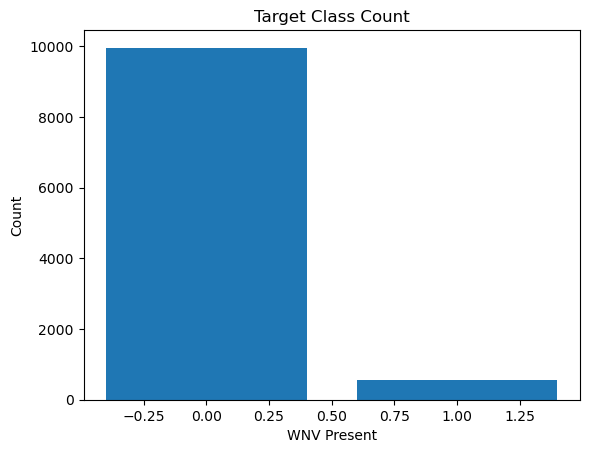

In [40]:
total_wnv_count = train_merge['WnvPresent'].value_counts().reset_index()
total_wnv_count.columns = ['WnvPresent','count']
display(total_wnv_count)

plt.bar(total_wnv_count['WnvPresent'],
        total_wnv_count['count']
)
plt.title('Target Class Count')
plt.xlabel('WNV Present')
plt.ylabel('Count')
plt.show()

In [41]:
# Separate input features (X) and target variable (y)
X = train_merge[['Species', 'Block', 'Street', 'Trap', 'Latitude',
       'Longitude', 'month', 'day', 'day_of_year', 'week',
       'Lat_int', 'Long_int', 'Station', 'stat_1_Tmax', 'stat_1_Tmin',
       'stat_1_Tavg', 'stat_1_PrecipTotal', 'DayLength_MPrec',
       'DayLength_nearH', 'Sunrise_hours', 'Sunset_hours', 'blended_Tmax',
       'blended_Tmin', 'blended_PrecipTotal', 'stat_2_Tmax',
       'stat_2_Tmin', 'stat_2_Tavg', 'stat_2_PrecipTotal']]
y = train_merge['WnvPresent']

# Define the categorical feature indices in X (indices of the categorical columns)
categorical_features = [0, 1, 2, 3]  # Adjust with the appropriate indices of your categorical columns

# Apply SMOTE-NC to the input features and target variable
smotenc = SMOTENC(categorical_features=categorical_features, random_state=99)
X_resampled, y_resampled = smotenc.fit_resample(X, y)

,WnvPresent,count
0,0,9955
1,1,9955


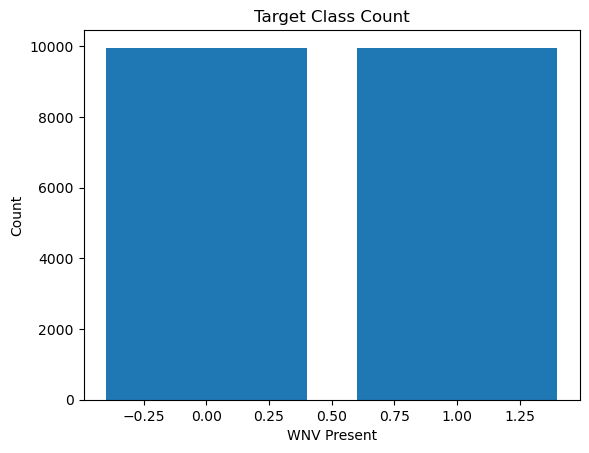

In [42]:
total_wnv_count = y_resampled.value_counts().reset_index()
total_wnv_count.columns = ['WnvPresent','count']
display(total_wnv_count)

plt.bar(total_wnv_count['WnvPresent'],
        total_wnv_count['count']
)
plt.title('Target Class Count')
plt.xlabel('WNV Present')
plt.ylabel('Count')
plt.show()

### Using OneHotEncoding to create Dummies

In [43]:
X_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19910 entries, 0 to 19909
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Species              19910 non-null  object 
 1   Block                19910 non-null  object 
 2   Street               19910 non-null  object 
 3   Trap                 19910 non-null  object 
 4   Latitude             19910 non-null  float64
 5   Longitude            19910 non-null  float64
 6   month                19910 non-null  int64  
 7   day                  19910 non-null  int64  
 8   day_of_year          19910 non-null  int64  
 9   week                 19910 non-null  int64  
 10  Lat_int              19910 non-null  int64  
 11  Long_int             19910 non-null  int64  
 12  Station              19910 non-null  object 
 13  stat_1_Tmax          19910 non-null  int64  
 14  stat_1_Tmin          19910 non-null  int64  
 15  stat_1_Tavg          19910 non-null 

In [44]:
X_resampled.columns

Index(['Species', 'Block', 'Street', 'Trap', 'Latitude', 'Longitude', 'month',
       'day', 'day_of_year', 'week', 'Lat_int', 'Long_int', 'Station',
       'stat_1_Tmax', 'stat_1_Tmin', 'stat_1_Tavg', 'stat_1_PrecipTotal',
       'DayLength_MPrec', 'DayLength_nearH', 'Sunrise_hours', 'Sunset_hours',
       'blended_Tmax', 'blended_Tmin', 'blended_PrecipTotal', 'stat_2_Tmax',
       'stat_2_Tmin', 'stat_2_Tavg', 'stat_2_PrecipTotal'],
      dtype='object')

In [45]:
# Create a function to perform the one hot encoding based on the selected categorical features from training data
def get_one_hot_encoded(data, cat_list, num_list):
    
    # Initialise One Hot Encoder & Column Transformer
    onehotencoder = OneHotEncoder(handle_unknown='ignore')
    transformer = ColumnTransformer([("enc",
                                       onehotencoder,
                                       cat_list)],
                                       remainder = "passthrough")
    
    # Fit the categorical feature names to transform on the housing dataset
    enc_data = transformer.fit(train_merge[cat_list])
    
    # Fill the train values
    enc_df = pd.DataFrame(transformer.transform(data[cat_list]).toarray())

    # Get the column Names
    enc_df.columns = transformer.get_feature_names_out(cat_list)

    # merge the encoded values with the numerical features
    merged_df = data[num_list].join(enc_df)
    
    return merged_df

In [46]:
# # get label
# labels = train_merge.pop('WnvPresent').values

In [47]:
# List of categorical features to encode and numerical features to select
cat_name_m1 = ['Species', 'Block','Street', 'Trap', 'Latitude', 'Longitude', 'Station']

num_name_m1 = ['month', 'day', 'day_of_year', 'week',
        'stat_1_Tmax', 'stat_1_Tmin',
        'stat_1_Tavg', 'stat_1_PrecipTotal', 'DayLength_MPrec',
        'DayLength_nearH', 'Sunrise_hours', 'Sunset_hours', 'blended_Tmax',
        'blended_Tmin', 'blended_PrecipTotal', 'stat_2_Tmax',
        'stat_2_Tmin', 'stat_2_Tavg', 'stat_2_PrecipTotal']

display(cat_name_m1)
display(num_name_m1)

['Species', 'Block', 'Street', 'Trap', 'Latitude', 'Longitude', 'Station']

['month',
 'day',
 'day_of_year',
 'week',
 'stat_1_Tmax',
 'stat_1_Tmin',
 'stat_1_Tavg',
 'stat_1_PrecipTotal',
 'DayLength_MPrec',
 'DayLength_nearH',
 'Sunrise_hours',
 'Sunset_hours',
 'blended_Tmax',
 'blended_Tmin',
 'blended_PrecipTotal',
 'stat_2_Tmax',
 'stat_2_Tmin',
 'stat_2_Tavg',
 'stat_2_PrecipTotal']

In [48]:
# Define the X & one Hot Encode those Categorical features for Model 1
model_train_df = get_one_hot_encoded(X_resampled, cat_name_m1, num_name_m1)
display(model_train_df.head())


,month,day,day_of_year,week,stat_1_Tmax,stat_1_Tmin,stat_1_Tavg,stat_1_PrecipTotal,DayLength_MPrec,DayLength_nearH,Sunrise_hours,Sunset_hours,blended_Tmax,blended_Tmin,blended_PrecipTotal,stat_2_Tmax,stat_2_Tmin,stat_2_Tavg,stat_2_PrecipTotal,enc__Species_CULEX ERRATICUS,enc__Species_CULEX PIPIENS,enc__Species_CULEX PIPIENS/RESTUANS,enc__Species_CULEX RESTUANS,enc__Species_CULEX SALINARIUS,enc__Species_CULEX TARSALIS,...,enc__Longitude_-87.612922,enc__Longitude_-87.61156,enc__Longitude_-87.605294,enc__Longitude_-87.604498,enc__Longitude_-87.600963,enc__Longitude_-87.60088,enc__Longitude_-87.599862,enc__Longitude_-87.598865,enc__Longitude_-87.590773,enc__Longitude_-87.586427,enc__Longitude_-87.585487,enc__Longitude_-87.585413,enc__Longitude_-87.582699,enc__Longitude_-87.565666,enc__Longitude_-87.562889,enc__Longitude_-87.559308,enc__Longitude_-87.55551,enc__Longitude_-87.546587,enc__Longitude_-87.543067,enc__Longitude_-87.538693,enc__Longitude_-87.536497,enc__Longitude_-87.535198,enc__Longitude_-87.531657,enc__Longitude_-87.531635,enc__Station_1
0,5,29,149,22,88,60,74.0,0.0,14.933333,15.0,4.35,19.283333,88.0,62.5,0.0,88,65,77.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,29,149,22,88,60,74.0,0.0,14.933333,15.0,4.35,19.283333,88.0,62.5,0.0,88,65,77.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,29,149,22,88,60,74.0,0.0,14.933333,15.0,4.35,19.283333,88.0,62.5,0.0,88,65,77.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,29,149,22,88,60,74.0,0.0,14.933333,15.0,4.35,19.283333,88.0,62.5,0.0,88,65,77.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,29,149,22,88,60,74.0,0.0,14.933333,15.0,4.35,19.283333,88.0,62.5,0.0,88,65,77.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# Define the X & one Hot Encode those Categorical features for Model 1
model_test_df = get_one_hot_encoded(test_merge, cat_name_m1, num_name_m1)
display(model_test_df.head())

,month,day,day_of_year,week,stat_1_Tmax,stat_1_Tmin,stat_1_Tavg,stat_1_PrecipTotal,DayLength_MPrec,DayLength_nearH,Sunrise_hours,Sunset_hours,blended_Tmax,blended_Tmin,blended_PrecipTotal,stat_2_Tmax,stat_2_Tmin,stat_2_Tavg,stat_2_PrecipTotal,enc__Species_CULEX ERRATICUS,enc__Species_CULEX PIPIENS,enc__Species_CULEX PIPIENS/RESTUANS,enc__Species_CULEX RESTUANS,enc__Species_CULEX SALINARIUS,enc__Species_CULEX TARSALIS,...,enc__Longitude_-87.612922,enc__Longitude_-87.61156,enc__Longitude_-87.605294,enc__Longitude_-87.604498,enc__Longitude_-87.600963,enc__Longitude_-87.60088,enc__Longitude_-87.599862,enc__Longitude_-87.598865,enc__Longitude_-87.590773,enc__Longitude_-87.586427,enc__Longitude_-87.585487,enc__Longitude_-87.585413,enc__Longitude_-87.582699,enc__Longitude_-87.565666,enc__Longitude_-87.562889,enc__Longitude_-87.559308,enc__Longitude_-87.55551,enc__Longitude_-87.546587,enc__Longitude_-87.543067,enc__Longitude_-87.538693,enc__Longitude_-87.536497,enc__Longitude_-87.535198,enc__Longitude_-87.531657,enc__Longitude_-87.531635,enc__Station_1
0,6,11,163,24,86,61,74.0,0.0,15.166667,15.0,4.266667,19.433333,86.0,63.5,0.0,86,66,76.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,6,11,163,24,86,61,74.0,0.0,15.166667,15.0,4.266667,19.433333,86.0,63.5,0.0,86,66,76.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,6,11,163,24,86,61,74.0,0.0,15.166667,15.0,4.266667,19.433333,86.0,63.5,0.0,86,66,76.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,6,11,163,24,86,61,74.0,0.0,15.166667,15.0,4.266667,19.433333,86.0,63.5,0.0,86,66,76.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6,11,163,24,86,61,74.0,0.0,15.166667,15.0,4.266667,19.433333,86.0,63.5,0.0,86,66,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [50]:
# I want these columns to be empty list
unique_test_cols = [col for col in test_merge.columns if col not in train_merge.columns]
unique_test_cols

[]

In [51]:
train_merge.dtypes

stat_1_Date            datetime64[ns]
Species                        object
Block                          object
Street                         object
Trap                           object
Latitude                      float64
Longitude                     float64
WnvPresent                      int64
month                           int64
day                             int64
day_of_year                     int64
week                            int64
Lat_int                         int64
Long_int                        int64
Station                        object
stat_1_Tmax                     int64
stat_1_Tmin                     int64
stat_1_Tavg                   float64
stat_1_PrecipTotal            float64
DayLength_MPrec               float64
DayLength_nearH               float64
Sunrise_hours                 float64
Sunset_hours                  float64
blended_Tmax                  float64
blended_Tmin                  float64
blended_PrecipTotal           float64
stat_2_Date 

In [66]:
# Select the X & y features
X = model_train_df
y = y_resampled
# Split the data into train & test by 70 / 30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

clf = ensemble.RandomForestClassifier(n_estimators=1000, min_samples_split= 2, random_state= 99)
clf.fit(X, y)

RandomForestClassifier(n_estimators=1000, random_state=99)

In [53]:
# Sanity Check for X_train, X_test, y_train and y_test

# # Convert the NumPy array to a Pandas Series
# y_test_series = pd.Series(y_test)

# # Calculate the value counts
# value_counts = np.unique(y_test_series, return_counts=True)

# # Print the value counts
# for value, count in zip(value_counts[0], value_counts[1]):
#     print(f"{value}: {count}")

In [54]:
# Make prediction with the model 
y_pred = clf.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
spec = tn / (tn + fp)

fp, tp, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fp, tp)

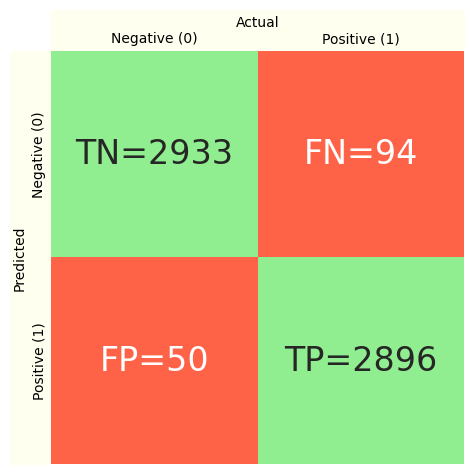

In [55]:
cm = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(data=cm, cmap=sns.color_palette(['tomato', 'lightgreen'], as_cmap=True), annot=[[f"TN={cm[0][0]:.0f}", fFN={cm[0][1]:.0f}"], [f"FP={cm[1][0]:.0f}", f"TP={cm[1][1]:.0f}"]],
                 fmt='', annot_kws={'fontsize': 24}, cbar=False, square=True)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.tick_params(length=0, labeltop=True, labelbottom=False)
ax.xaxis.set_label_position('top')
ax.set_xticklabels(['Negative (0)', 'Positive (1)'])
ax.set_yticklabels(['Negative (0)', 'Positive (1)'], rotation=90, va='center')
ax.add_patch(plt.Rectangle((0, 1), 1, 0.1, color='ivory', clip_on=False, zorder=0, transform=ax.transAxes))
ax.add_patch(plt.Rectangle((0, 0), -0.1, 1, color='ivory', clip_on=False, zorder=0, transform=ax.transAxes))
plt.tight_layout()
plt.show()

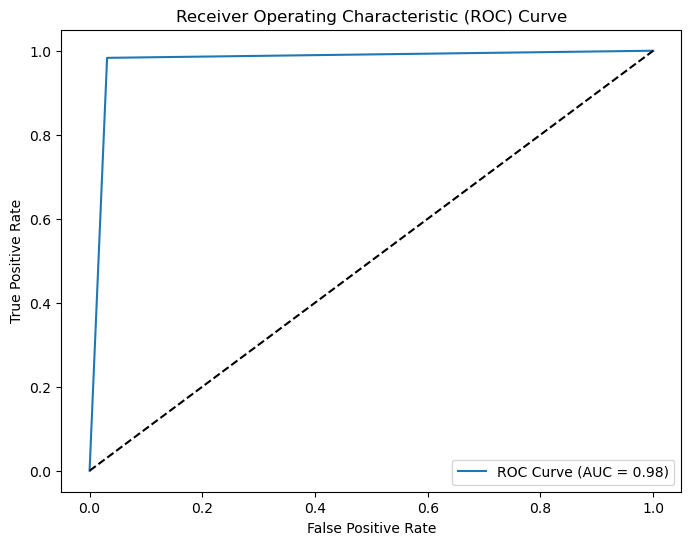

In [56]:
# Calculate the ROC AUC score
roc_auc_test = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fp, tp, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Writing a function to consolidate the modelling process

In [60]:
# Define a function that returns the model scores
# Set view_cm to True to get confusion matrix visualisation
def get_model_score (X, y, pipe, view_cm = False, view_roc = False):
    
    # Split the data into train & test by 70 / 30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)
    
    #  the data
    pipe.fit(X_train, y_train)
    display(pipe) # Remove is there is an error
    
    # Make prediction with the model 
    y_pred = pipe.predict(X_test)
    
    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    spec = tn / (tn + fp)
    
    fp, tp, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fp, tp)

    print(classification_report(y_test, y_pred))
    print(f'Accuracy (train): {pipe.score(X_train, y_train)}')
    print(f'Accuracy (test): {pipe.score(X_test, y_test)}')
#     print(f'Cross-val-score(cv=5): {cross_val_score(pipe, X_train, y_train, cv=5).mean()}')
    print(f'Sensitivity(TPR): {recall_score(y_test, y_pred)}')
    print(f'Specificity(TNR): {spec}')
    print(f'Precision: {precision_score(y_test, y_pred)}')
    print(f'ROC_AUC: {roc_auc}')
    print('-------------------------------------------------------\n')
    
    if view_cm: 
        
        cm = confusion_matrix(y_test, y_pred)

        ax = sns.heatmap(data=cm, cmap=sns.color_palette(['tomato', 'lightgreen'], as_cmap=True), annot=[[f"TN={cm[0][0]:.0f}", f"FN={cm[0][1]:.0f}"], [f"FP={cm[1][0]:.0f}", f"TP={cm[1][1]:.0f}"]],
                         fmt='', annot_kws={'fontsize': 24}, cbar=False, square=True)

        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
        ax.tick_params(length=0, labeltop=True, labelbottom=False)
        ax.xaxis.set_label_position('top')
        ax.set_xticklabels(['Negative (0)', 'Positive (1)'])
        ax.set_yticklabels(['Negative (0)', 'Positive (1)'], rotation=90, va='center')
        ax.add_patch(plt.Rectangle((0, 1), 1, 0.1, color='ivory', clip_on=False, zorder=0, transform=ax.transAxes))
        ax.add_patch(plt.Rectangle((0, 0), -0.1, 1, color='ivory', clip_on=False, zorder=0, transform=ax.transAxes))
        plt.tight_layout()
        plt.show()
    
    if view_roc:
        
        # Calculate the ROC AUC score
        roc_auc_test = roc_auc_score(y_test, y_pred)

        # Plot the ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fp, tp, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_test))
        plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line for reference
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
    
    return

Random Forest Classifier


Pipeline(steps=[('clf',
                 RandomForestClassifier(n_estimators=1000, random_state=99))])

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      3027
           1       0.92      0.96      0.94      2946

    accuracy                           0.94      5973
   macro avg       0.94      0.94      0.94      5973
weighted avg       0.94      0.94      0.94      5973

Accuracy (train): 0.9814163736815671
Accuracy (test): 0.9362129583124058
Sensitivity(TPR): 0.9558723693143245
Specificity(TNR): 0.9170796167822927
Precision: 0.9181610694489729
ROC_AUC: 0.9364759930483085
-------------------------------------------------------



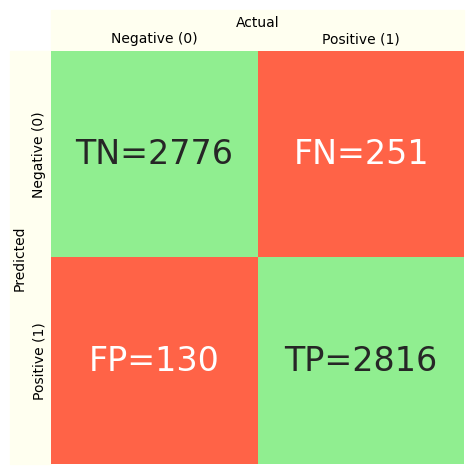

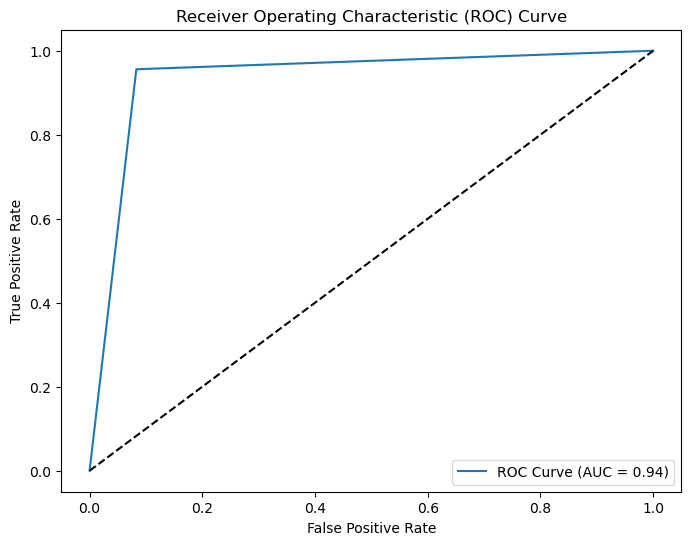

In [67]:
# Select the X & y features
X = model_train_df
y = y_resampled

# Create a custom transformer for the RandomForestClassifier
rf_transformer = FunctionTransformer(lambda x: x, validate=False)

# Logistic Regression with CountVectorizer
clf = Pipeline([
    ('clf', ensemble.RandomForestClassifier(n_estimators=1000, min_samples_split=2, random_state=99)),
])  # Add closing parenthesis for Pipeline constructor

print('Random Forest Classifier')
get_model_score(X, y, clf, view_cm=True, view_roc=True)


# (5) Model Tuning


In [59]:
def select_features_by_importance_threshold(model, X_train, y_train, selection_model, X_test, y_test,
                                           minimum = False):

    # Fit model using each importance as a threshold
    if minimum:
        thresholds= np.unique(model.feature_importances_[model.feature_importances_ > minimum])
        # include 0 for all features
        thresholds = np.insert(thresholds, 0, 0.)
    else:
        thresholds= np.unique(model.feature_importances_)
        
    
    print(thresholds)
    for thresh in thresholds:
	    # select features using threshold
        selection = feature_selection.SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
	    # train model
        selection_model = selection_model
        selection_model.fit(select_X_train, y_train)
	    # eval model
        select_X_test = selection.transform(X_test)
        y_pred = selection_model.predict_proba(select_X_test)[:,1]
        predictions = y_pred
        #predictions = [round(value) for value in y_pred]
        auc = calc_roc_auc(y_test, predictions)
        print("Thresh=%.3f, n=%d, AUC: %.2f%%" % (thresh, select_X_train.shape[1], auc))

# (6) Model Evaluation


In [ ]:
def calc_roc_auc(y, predict_probs):
    
    """
    Function accepts labels (matriloc y) and predicted probabilities
    Function calculates fpr (false positive rate), tpr (true postivies rate), thresholds and auc (area under
    the roc curve)
    Function returns auc
    """
    fpr, tpr, thresholds = metrics.roc_curve(y, predict_probs)
    roc_auc = metrics.auc(fpr, tpr)
    
    return roc_auc

# Key Insights and Recommendation

# Kaggle Submission

In [ ]:
# Select the X & y features
X = model_test_df
y_pred = clf.predict(X)

In [ ]:
y_pred = pd.DataFrame(y_pred)
y_pred

In [ ]:
y_pred.iloc[:,0].value_counts()

sample_sub['WnvPresent'] = y_pred.iloc[:,0]

sample_sub['WnvPresent'].value_counts()

sample_sub.to_csv('kaggle_submission.csv')